## Basic Dataset

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

class SinDataset(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset with the data.

        Args:
            data (list or array-like): List of numbers to use as data.
        """
        self.data = data
        self.x = data
        self.y = np.sin(data)

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Fetch the data and its label at index `idx`.

        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: (data, label) where label is the square of the data.
        """
        x = self.data[idx]  # Get the input data
        y = np.sin(x)         # Label is the square of the input
        return x, y


## Create and Test Dataset

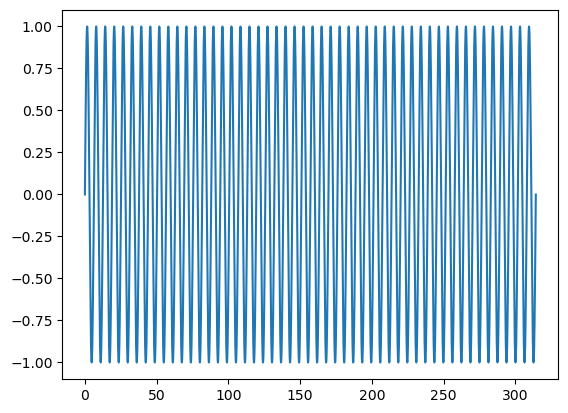

In [2]:
# Create an instance of the dataset
numbers = np.linspace(0, 100*np.pi, 100000)  # Data: [1, 2, 3, ..., 10]
dataset = SinDataset(numbers)
plt.plot(dataset.x, dataset.y)


## Use with DataLoader

In [4]:
from torch.utils.data import DataLoader

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=10000, shuffle=False)

# Iterate through the DataLoader
for batch in dataloader:
    x_batch, y_batch = batch
    print(f"Batch Inputs: {len(x_batch)}, Batch Labels: {len(y_batch)}")


Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000
Batch Inputs: 10000, Batch Labels: 10000


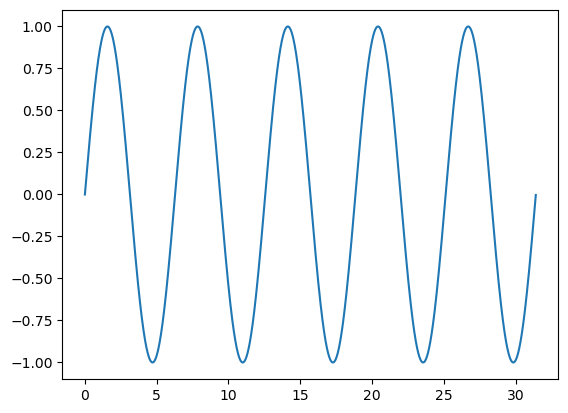

In [5]:
for x, y in dataloader:
    plt.plot(x, y)
    break

## Splitting the Dataset with random_split

In [6]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Check the sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 80000
Test set size: 20000


## Setting up an LSTM

In [19]:
X_train = np.arange(0,50,0.1)
y1_train = np.sin(X_train) # + np.sin(3*X_train)/3 + np.sin(5*X_train)/5
y2_train = np.sin(X_train-10) # + np.sin(3*X_train)/3 + np.sin(5*X_train)/5

X_test = np.arange(50,100,0.1)
y_test = np.sin(X_test) #  + np.sin(3*X_train)/3 + np.sin(5*X_train)/5
y2_test = np.sin(X_test-10) # + np.sin(3*X_train)/3 + np.sin(5*X_train)/5

n_features = 1

train_series = [y1_train, y2_train]
test_series  = [y1_test, y2_test]

train_series = torch.from_numpy(train_series)
test_series = torch.from_numpy(test_series)

NameError: name 'y1_test' is not defined

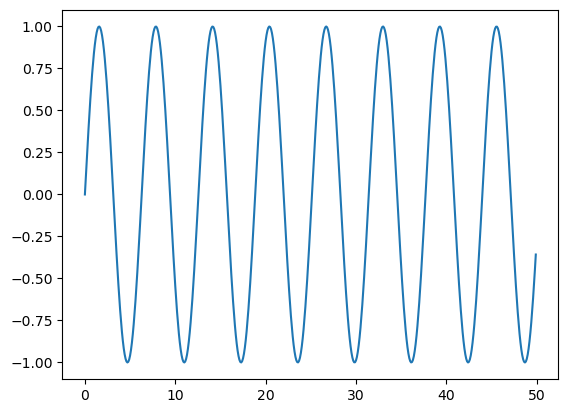

In [8]:
plt.plot(X_train, y_train)

In [9]:
# LSTM expects input of (sequence, batch, features)
# So shape should be (180, 1, 20) and labels (1, 1, 180)
look_back = 20

train_dataset = []
train_labels = []
for i in range(len(train_series)-look_back):
    train_dataset.append(train_series[i:i+look_back])
    train_labels.append(train_series[i+look_back])
train_dataset = torch.stack(train_dataset).unsqueeze(1)
train_labels = torch.stack(train_labels).unsqueeze(1).unsqueeze(2)

In [10]:
train_labels.shape, train_dataset.shape

(torch.Size([480, 1, 1]), torch.Size([480, 1, 20]))

In [14]:
class Net(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_shape, n_neurons)
        self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
        self.fc = nn.Linear(n_neurons, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(x)
        out = self.fc(out)
        return out
    

In [18]:
n_neurons = 12

model = Net(n_neurons, look_back).double()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_curve = []
for epoch in range(300):
    loss_total = 0
    
    model.zero_grad()
    
    predictions = model(train_dataset)
    
    loss = loss_function(predictions, train_labels)
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

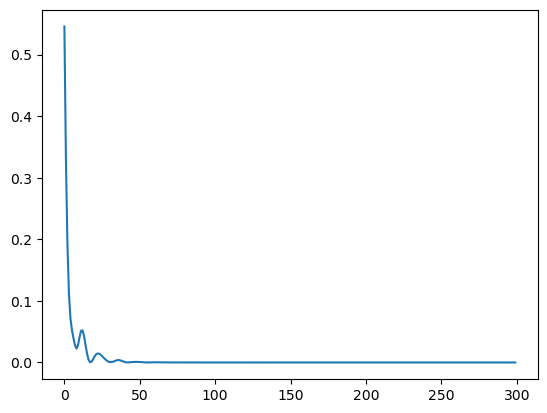

In [14]:
plt.plot(loss_curve)

In [15]:
# LSTM expects input of (sequence, batch, features)
# So shape should be (1, 180, 20)
test_dataset = [test_series[i:i+look_back] for i in range(len(test_series)-look_back)]
test_dataset = torch.stack(test_dataset).unsqueeze(0)

with torch.no_grad():
    test_predictions = model(test_dataset).squeeze()

In [16]:
test_predictions.shape

torch.Size([480])

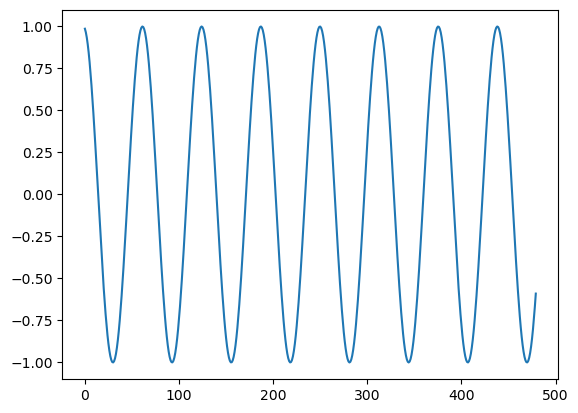

In [17]:
plt.plot(test_predictions)

## Approach from https://cnvrg.io/pytorch-lstm/

In [4]:

from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dtype=torch.float64) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        # Propagate input through LSTM
        #assert x
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

In [5]:
# LSTM expects input of (sequence, batch, features)
# So shape should be (180, 1, 20) and labels (1, 1, 180)
look_back = 20

train_dataset = []
train_labels = []
for i in range(len(train_series)-look_back):
    train_dataset.append(train_series[i:i+look_back])
    train_labels.append(train_series[i+look_back])
train_dataset = torch.stack(train_dataset).unsqueeze(1)
train_labels = torch.stack(train_labels).unsqueeze(1)

In [6]:
train_dataset.dtype

torch.float64

In [7]:
train_dataset.shape, train_labels.shape

(torch.Size([80, 1, 20]), torch.Size([80, 1]))

In [13]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = look_back #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [19]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, look_back)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [20]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(train_dataset) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, train_labels)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

## Playing with LSTMs

In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print('---')
print(hidden)

tensor([[[ 0.2490, -0.0525,  0.3253]],

        [[ 0.1655, -0.0304,  0.3348]],

        [[-0.1104, -0.1085,  0.7568]],

        [[-0.0148, -0.0855,  0.4162]],

        [[ 0.0703, -0.1089,  0.2071]]], grad_fn=<MkldnnRnnLayerBackward0>)
---
(tensor([[[ 0.0703, -0.1089,  0.2071]]], grad_fn=<StackBackward0>), tensor([[[ 0.2099, -0.3541,  0.9947]]], grad_fn=<StackBackward0>))
